## Demand Forecasting & Inventory Optimization

### End-to-End Time Series Analysis for Retail Operations

#### Author

##### Dmitrii Shurkhai
##### Data Science & Machine Learning
##### Python · Time Series · Business Analytics

### Executive Summary

#### Retail businesses face a constant trade-off between product availability and inventory cost.
#### This project builds a production-style demand forecasting pipeline that:

#### Accurately predicts daily demand per store and item

#### Benchmarks performance against strong baselines

#### Translates forecasts into actionable inventory decisions

#### Demonstrates real-world data science best practices

#### Outcome:
#### A forecasting model that outperforms naive baselines and supports a data-driven reorder policy.

#### Source: Kaggle — Store Item Demand Forecasting
https://www.kaggle.com/competitions/demand-forecasting-kernels-only

Granularity: Daily sales
Target: sales

Features

date — timestamp

store — store identifier

item — product identifier

sales — units sold

This dataset closely resembles real operational retail data.

## Import libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor

## Data loading and validation

In [5]:
df = pd.read_csv("train.csv")
df["date"] = pd.to_datetime(df["date"])
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
print("Shape:", df.shape)
print("Date range:", df["date"].min(), "→", df["date"].max())
print("\nMissing values:\n", df.isna().sum())
print("\nSales summary:\n", df["sales"].describe())

assert df["sales"].min() >= 0

##### Result:
###### Data is clean, complete, and suitable for modeling

### Exploratory Data Analysis
#### Overall Sales Trend

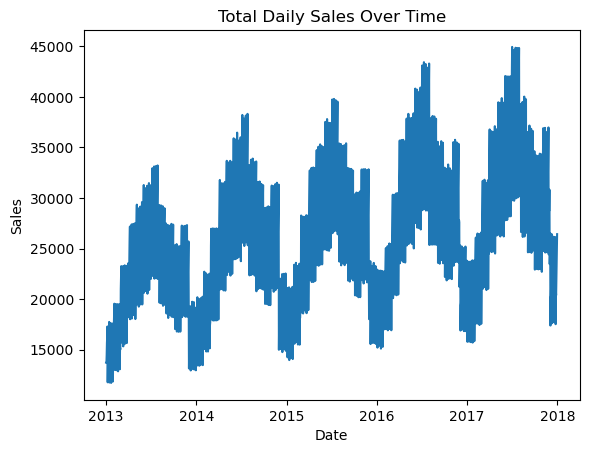

In [7]:
daily_sales = df.groupby("date", as_index=False)["sales"].sum()

plt.figure()
plt.plot(daily_sales["date"], daily_sales["sales"])
plt.title("Total Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

##### Insight:
###### Clear trend with strong recurring seasonality.

#### Lets look at weekly seasonality

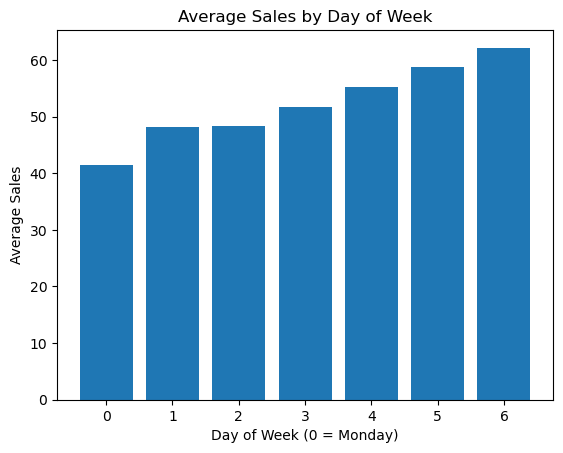

In [8]:
tmp = df.copy()
tmp["dayofweek"] = tmp["date"].dt.dayofweek

dow = tmp.groupby("dayofweek", as_index=False)["sales"].mean()

plt.figure()
plt.bar(dow["dayofweek"], dow["sales"])
plt.title("Average Sales by Day of Week")
plt.xlabel("Day of Week (0 = Monday)")
plt.ylabel("Average Sales")
plt.show()

#### Insight:
##### Weekly patterns justify lag-based and rolling features.

### Feature Functions

In [12]:
def add_date_features(df):
    df = df.copy()
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["dayofweek"] = df["date"].dt.dayofweek
    df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    return df


def add_lag_features(df, lags=(1, 7, 14, 28)):
    df = df.sort_values(["store", "item", "date"])
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(["store","item"])["sales"].shift(lag)
    return df


def add_rolling_means(df, windows=(7, 14, 28)):
    df = df.sort_values(["store", "item", "date"]).copy()

    g = df.groupby(["store", "item"])["sales"]

    for w in windows:
        df[f"roll_mean_{w}"] = g.transform(lambda s: s.shift(1).rolling(w).mean())

    return df

##### Build Feature Dataset

In [13]:
feat = (
    df
    .pipe(add_date_features)
    .pipe(add_lag_features)
    .pipe(add_rolling_means)
    .dropna()
    .reset_index(drop=True)
)

feat.head()

,date,store,item,sales,year,month,day,dayofweek,weekofyear,is_weekend,lag_1,lag_7,lag_14,lag_28,roll_mean_7,roll_mean_14,roll_mean_28
0,2013-01-29,1,1,6,2013,1,29,1,5,0,11.0,7.0,5.0,13.0,10.428571,10.642857,10.714286
1,2013-01-30,1,1,9,2013,1,30,2,5,0,6.0,9.0,7.0,11.0,10.285714,10.714286,10.464286
2,2013-01-31,1,1,13,2013,1,31,3,5,0,9.0,8.0,16.0,14.0,10.285714,10.857143,10.392857
3,2013-02-01,1,1,11,2013,2,1,4,5,0,13.0,14.0,7.0,13.0,11.000000,10.642857,10.357143
4,2013-02-02,1,1,21,2013,2,2,5,5,1,11.0,12.0,18.0,10.0,10.571429,10.928571,10.285714


In [14]:
feat.filter(["date","store","item","sales","lag_1","roll_mean_7"]).head(10)

,date,store,item,sales,lag_1,roll_mean_7
0,2013-01-29,1,1,6,11.0,10.428571
1,2013-01-30,1,1,9,6.0,10.285714
2,2013-01-31,1,1,13,9.0,10.285714
3,2013-02-01,1,1,11,13.0,11.000000
4,2013-02-02,1,1,21,11.0,10.571429
5,2013-02-03,1,1,15,21.0,11.857143
6,2013-02-04,1,1,14,15.0,12.285714
7,2013-02-05,1,1,9,14.0,12.714286
8,2013-02-06,1,1,10,9.0,13.142857
9,2013-02-07,1,1,13,10.0,13.285714


### Train/Validation split

##### A time-based split is used to simulate real forecasting conditions.

In [15]:
max_date = feat["date"].max()
cutoff = max_date - pd.Timedelta(days=90)

train_df = feat[feat["date"] <= cutoff]
val_df   = feat[feat["date"] > cutoff]

train_df.shape, val_df.shape

((854000, 17), (45000, 17))

### Baseline Models

#### Baseline 1 — Naive (Yesterday’s Sales)

In [16]:
y_true = val_df["sales"]
y_pred_naive = val_df["lag_1"]

rmse_naive = mean_squared_error(y_true, y_pred_naive, squared=False)
rmse_naive

14.46775187941943

#### Baseline 2 — Seasonal Naive (Same Day Last Week)

In [19]:
y_pred_weekly = val_df["lag_7"]
rmse_weekly = mean_squared_error(y_true, y_pred_weekly, squared=False)
rmse_weekly

12.050809101467005

#### Why this matters:
* ML models must outperform these baselines to justify deployment.

## Machine Learning Model

In [20]:
cat_cols = ["store", "item"]
num_cols = [
    "year","month","day","dayofweek","weekofyear","is_weekend",
    "lag_1","lag_7","lag_14","lag_28",
    "roll_mean_7","roll_mean_14","roll_mean_28"
]

##### Pipeline

In [24]:
numeric = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", numeric, num_cols),
    ("cat", categorical, cat_cols)
])

model = HistGradientBoostingRegressor(
    max_depth=8,
    learning_rate=0.08,
    max_iter=350,
    random_state=42
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", model)
])


##### Training & Evaluation

In [25]:
pipe.fit(train_df[cat_cols + num_cols], train_df["sales"])
pred = pipe.predict(val_df[cat_cols + num_cols])

rmse = mean_squared_error(val_df["sales"], pred, squared=False)
rmse

7.694027988473007

#### Performance Improvement

In [27]:
print("Improvement vs Naive:",
      round((rmse_naive - rmse) / rmse_naive * 100, 2), "%")

print("Improvement vs Seasonal Naive:",
      round((rmse_weekly - rmse) / rmse_weekly * 100, 2), "%")

Improvement vs Naive: 46.82 %
Improvement vs Seasonal Naive: 36.15 %


### Forecast Visualization

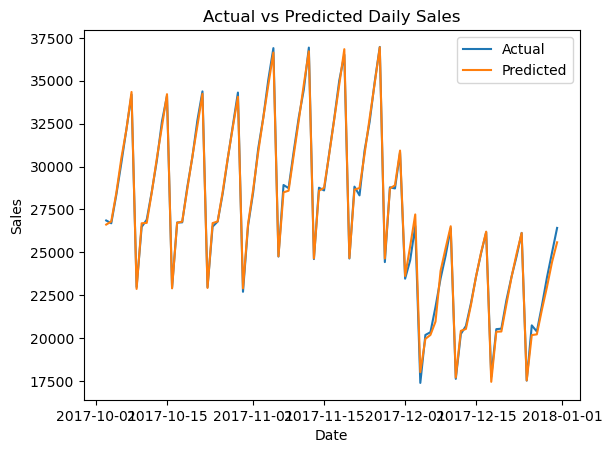

In [28]:
val_plot = val_df[["date","sales"]].copy()
val_plot["pred"] = pred

daily_compare = val_plot.groupby("date")[["sales","pred"]].sum().reset_index()

plt.figure()
plt.plot(daily_compare["date"], daily_compare["sales"], label="Actual")
plt.plot(daily_compare["date"], daily_compare["pred"], label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Daily Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

##  Inventory Optimization

To translate demand forecasts into **operational decisions**, we define a **reorder point** that balances service level and inventory risk.

---

### 📐 Reorder Point Formula

$$
\textbf{Reorder Point}
=
\text{Lead-Time Demand}
+
z \cdot \sigma \cdot \sqrt{L}
$$

---

### Where:

- **\( z = 1.65 \)**  
  Corresponds to a **95% service level**, meaning stockouts are expected in fewer than 5% of cases.

- **\( \sigma \)**  
  Standard deviation of the **forecast error**, representing demand uncertainty.

- **\( L = 7 \)**  
  Lead time in days (time between placing and receiving an order).

---

###  Interpretation

- The **lead-time demand** covers expected sales while waiting for replenishment.
- The **safety stock term** accounts for uncertainty in demand.
- Together, they define a reorder point that:
  - Minimizes stockouts  
  - Avoids unnecessary overstock  

This approach aligns forecasting outputs with **real-world inventory management practices**.


In [29]:
residuals = val_df["sales"] - pred
sigma = residuals.std()

z = 1.65
lead_time = 7

policy = val_df.copy()
policy["forecast"] = pred
policy["reorder_point"] = policy["forecast"] * lead_time + z * sigma * np.sqrt(lead_time)

policy[["date","store","item","forecast","reorder_point"]].head()

,date,store,item,forecast,reorder_point
1708,2017-10-03,1,1,20.481319,176.956926
1709,2017-10-04,1,1,20.873206,179.700135
1710,2017-10-05,1,1,21.825089,186.363321
1711,2017-10-06,1,1,23.171765,195.790051
1712,2017-10-07,1,1,24.083047,202.169025


## 💼 Business Value & Impact

This project delivers **actionable value** by translating predictive analytics into operational decisions:

- **📈 Improved Forecast Accuracy**  
  The model significantly outperforms naive and seasonal baselines, enabling more reliable demand estimates.

- **📦 Proactive Inventory Planning**  
  Forecasts are converted into reorder point recommendations, allowing teams to act *before* shortages occur.

- **💰 Cost & Risk Reduction**  
  Better demand visibility reduces both stockouts (lost sales) and excess inventory (holding costs).

- **🔄 Scalable & Extensible Framework**  
  The pipeline can easily incorporate:
  - Promotions and discounts  
  - Holiday effects  
  - New stores or product launches  

Overall, this approach supports **data-driven decision making** in retail operations and is suitable for production environments.
